# Importing Libraries and Data Preprocessing

In [1]:
import os
from collections import Counter
import sys
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageColor, ImageFont
import random
from skimage.feature import hog
import cv2
from sklearn.svm import SVC, OneClassSVM
from sklearn.metrics import accuracy_score, fbeta_score, precision_score, recall_score, classification_report
from sklearn.model_selection import train_test_split
import time

random.seed(1234)

In [2]:
# Load data dictionary
input_dir = 'train_images/'

In [3]:
# Load meta data
data_df = pd.read_csv('train.csv')
data_df

video_id  sequence  video_frame  sequence_frame image_id annotations
0             0     40258            0               0      0-0          []
1             0     40258            1               1      0-1          []
2             0     40258            2               2      0-2          []
3             0     40258            3               3      0-3          []
4             0     40258            4               4      0-4          []
...         ...       ...          ...             ...      ...         ...
23496         2     29859        10755            2983  2-10755          []
23497         2     29859        10756            2984  2-10756          []
23498         2     29859        10757            2985  2-10757          []
23499         2     29859        10758            2986  2-10758          []
23500         2     29859        10759            2987  2-10759          []

[23501 rows x 6 columns]

In [4]:
# video_id - ID number of the video the image was part of
data_df.video_id.unique()

array([0, 1, 2])

In [5]:
# sequence - ID of a gap-free subset of a given video.
data_df.sequence.unique()

array([40258, 45518, 59337,  8399, 45015, 35305, 53708,   996, 60510,
       44160, 15827, 29424,  8503, 18048, 17665, 60754, 37114, 26651,
       22643, 29859])

In [7]:
# Tha ratio of images with or witout starfish
ann_num = len(data_df[data_df.annotations != '[]'])
noann_num = len(data_df[data_df.annotations == '[]'])
print('The ratio of images with annotations:', float(ann_num/len(data_df)))
print('The ratio of images without annotations:', float(noann_num/len(data_df)))

The ratio of images with annotations: 0.20931024211735672
The ratio of images without annotations: 0.7906897578826433


In [22]:
# Use only images with starfish
use_data_df = data_df[data_df.annotations != '[]'].reset_index(drop=False)
# Change annotations datatype from string to list and add filepath for each image
use_data_df["annotations"] = use_data_df["annotations"].map(lambda x: eval(x))
use_data_df["filepath"] = use_data_df.apply(lambda x : f"train_images/video_{x.video_id}/{x.video_frame}.jpg", axis=1)
use_data_df

index  video_id  sequence  video_frame  sequence_frame image_id  \
0        16         0     40258           16              16     0-16   
1        17         0     40258           17              17     0-17   
2        18         0     40258           18              18     0-18   
3        19         0     40258           19              19     0-19   
4        20         0     40258           20              20     0-20   
...     ...       ...       ...          ...             ...      ...   
4914  23369         2     29859        10628            2856  2-10628   
4915  23370         2     29859        10629            2857  2-10629   
4916  23371         2     29859        10630            2858  2-10630   
4917  23372         2     29859        10631            2859  2-10631   
4918  23373         2     29859        10632            2860  2-10632   

                                            annotations  \
0     [{'x': 559, 'y': 213, 'width': 50, 'height': 32}]   
1     [{'x': 558, 'y': 213, 'width': 50, 'height': 32}]   
2     [{'x': 557, 'y': 213, 'width': 50, 'height': 32}]   
3     [{'x': 556, 'y': 214, 'width': 50, 'height': 32}]   
4     [{'x': 555, 'y': 214, 'width': 50, 'height': 32}]   
...                                                 ...   
4914   [{'x': 92, 'y': 532, 'width': 40, 'height': 37}]   
4915   [{'x': 78, 'y': 569, 'width': 40, 'height': 37}]   
4916   [{'x': 65, 'y': 606, 'width': 41, 'height': 37}]   
4917   [{'x': 51, 'y': 643, 'width': 44, 'height': 37}]   
4918   [{'x': 38, 'y': 681, 'width': 46, 'height': 37}]   

                            filepath  
0        train_images/video_0/16.jpg  
1        train_images/video_0/17.jpg  
2        train_images/video_0/18.jpg  
3        train_images/video_0/19.jpg  
4        train_images/video_0/20.jpg  
...                              ...  
4914  train_images/video_2/10628.jpg  
4915  train_images/video_2/10629.jpg  
4916  train_images/video_2/10630.jpg  
4917  train_images/video_2/10631.jpg  
4918  train_images/video_2/10632.jpg  

[4919 rows x 8 columns]

In [23]:
# Split useful data with ratio 0.8 according to unique sequence
split_ratio = 0.8
split_index = int(split_ratio * len(use_data_df))
if use_data_df.iloc[split_index - 1].sequence == use_data_df.iloc[split_index].sequence:
    seq = use_data_df.iloc[split_index].sequence
    split_index = use_data_df.loc[use_data_df['sequence'] == seq].index[-1] + 1
split_index

4242

In [24]:
train_data_df = use_data_df[:split_index].sample(frac = 1).reset_index(drop=True)
test_data_df = use_data_df[split_index:].sample(frac = 1).reset_index(drop=True)
print('Number of positive images used for training:', len(train_data_df))
print('Number of positive images used for testing:', len(test_data_df))

Number of positive images used for training: 4242
Number of positive images used for testing: 677


In [35]:
# Change annotations as YOLO input format
X, Y = 1280, 720
pos_data_df = train_data_df[['index','filepath','annotations']]
pos_data_df["bboxes"] = pos_data_df.apply(lambda a: [{'xc':round((i['x']+(i['width']/2))/X, 6),
                                                      'yc':round((i['y']+(i['height']/2))/Y, 6),
                                                      'w':round(i['width']/X, 6),'h':round(i['height']/Y, 6)}
                                                     for i in a.annotations], axis=1)
pos_data_df['label'] = 1

pos_data_df

/var/folders/4z/70kzc6jx0c190007spxhkkqh0000gn/T/ipykernel_12122/3215988408.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_data_df["bboxes"] = pos_data_df.apply(lambda a: [{'xc':round((i['x']+(i['width']/2))/X, 6),
/var/folders/4z/70kzc6jx0c190007spxhkkqh0000gn/T/ipykernel_12122/3215988408.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_data_df['label'] = 1


index                        filepath  \
0      9360   train_images/video_1/4208.jpg   
1      4735   train_images/video_0/8912.jpg   
2      2737   train_images/video_0/4660.jpg   
3      6278  train_images/video_0/11918.jpg   
4      2562   train_images/video_0/4485.jpg   
...     ...                             ...   
4237   9593   train_images/video_1/4441.jpg   
4238   8028   train_images/video_1/1920.jpg   
4239   6265  train_images/video_0/11905.jpg   
4240  12386   train_images/video_1/8821.jpg   
4241   7325    train_images/video_1/617.jpg   

                                            annotations  \
0     [{'x': 286, 'y': 361, 'width': 42, 'height': 3...   
1     [{'x': 528, 'y': 462, 'width': 30, 'height': 24}]   
2     [{'x': 663, 'y': 117, 'width': 28, 'height': 26}]   
3     [{'x': 1061, 'y': 456, 'width': 72, 'height': ...   
4     [{'x': 131, 'y': 311, 'width': 48, 'height': 23}]   
...                                                 ...   
4237   [{'x': 634, 'y': 75, 'width': 32, 'height': 42}]   
4238  [{'x': 919, 'y': 500, 'width': 33, 'height': 37}]   
4239  [{'x': 1013, 'y': 265, 'width': 65, 'height': ...   
4240  [{'x': 584, 'y': 198, 'width': 47, 'height': 4...   
4241  [{'x': 589, 'y': 103, 'width': 167, 'height': ...   

                                                 bboxes  label  
0     [{'xc': 0.239844, 'yc': 0.527778, 'w': 0.03281...      1  
1     [{'xc': 0.424219, 'yc': 0.658333, 'w': 0.02343...      1  
2     [{'xc': 0.528906, 'yc': 0.180556, 'w': 0.02187...      1  
3     [{'xc': 0.857031, 'yc': 0.689583, 'w': 0.05625...      1  
4     [{'xc': 0.121094, 'yc': 0.447917, 'w': 0.0375,...      1  
...                                                 ...    ...  
4237  [{'xc': 0.507812, 'yc': 0.133333, 'w': 0.025, ...      1  
4238  [{'xc': 0.730859, 'yc': 0.720139, 'w': 0.02578...      1  
4239  [{'xc': 0.816797, 'yc': 0.411806, 'w': 0.05078...      1  
4240  [{'xc': 0.474609, 'yc': 0.304861, 'w': 0.03671...      1  
4241  [{'xc': 0.525391, 'yc': 0.232639, 'w': 0.13046...      1  

[4242 rows x 5 columns]

In [45]:
print("The number of Starfish images for SVM classifier:", np.sum(pos_data_df.annotations.str.len()))

The number of Starfish images for SVM classifier: 9449


In [47]:
# Select a certain amount of images randomly in the crop to generate negative samples
# The ratio of positive samples and negative samples around 1:1
neg_data_df = train_data_df[train_data_df.annotations.str.len()>=10].reset_index(drop=False)[['filepath']]
anns = []
for i in range(len(neg_data_df)):
    x = np.random.randint(0, X - 32, 64)
    y = np.random.randint(0, Y - 32, 64)
    ann = [{'x': x[i], 'y': y[i], 'width': 32, 'height': 32} for i in range(64)]
    anns.append(str(ann))
neg_data_df['annotations'] = np.array(anns)
neg_data_df['annotations'] = neg_data_df['annotations'].map(lambda x : eval(x))
neg_data_df['label'] = 0
print("The number of Background images for SVM classifier:", np.sum(neg_data_df.annotations.str.len()))

The number of Background images for SVM classifier: 9472


In [12]:
def plot_img(path, boxes):
    '''Plot single image with different colored bounding boxes and the number of boxes'''
    img = Image.open(path)
    fnt = ImageFont.truetype("/Library/Fonts/Arial.ttf", 40)

    n = len(boxes)
#     generate random colors for each bounding boxes
    colours_r = random.sample(range(256), n)
    colours_g = random.sample(range(256), n)
    colours_b = random.sample(range(256), n)
#     add bounding boxes
    for i in range(n):
        colour = (colours_r[i], colours_g[i], colours_b[i])
        box = boxes[i]
        shape = [(box['x'], box['y']), (box['x']+box['width'], box['y']+box['height'])]
        ImageDraw.Draw(img).rectangle(shape, outline=colour, width=3)
#     add the number of bounding boxes at the top left
    ImageDraw.Draw(img).text((5, 5), str(n), font=fnt) 
    display(img)

train_images/video_2/5743.jpg
(720, 1280, 3)
16


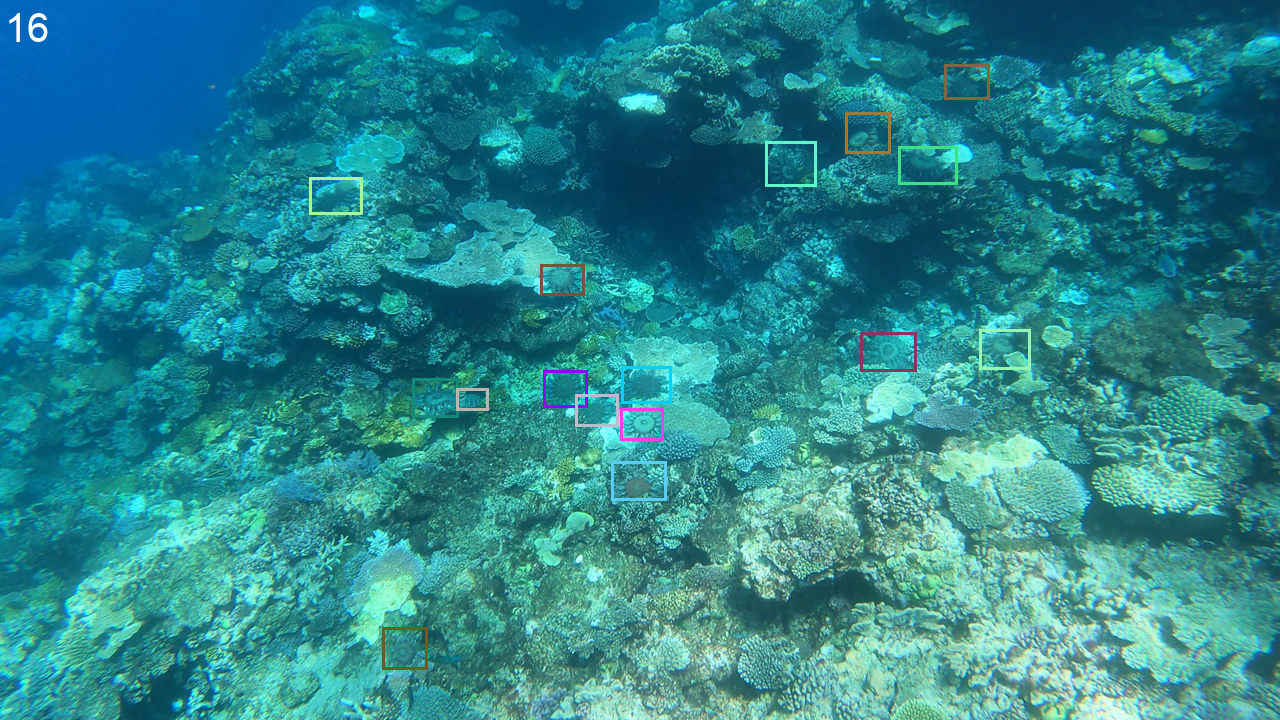

In [87]:
# Show an image sample
idx = 19645

path = data_df.filepath[idx]
print(path)
img = cv2.imread(path)
print(img.shape)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
boxes = data_df.annotations[idx]
print(len(boxes))
pos_imgs = []
for box in boxes:
    roi = img[box['y']:box['y']+box['height'], box['x']:box['x']+box['width']]
    pos_imgs.append(roi)

plot_img(path, boxes)

(32, 42, 3)


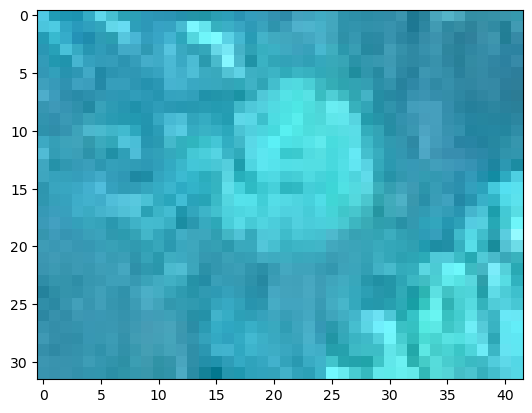

In [296]:
# Show a starfish image sample
plt.imshow(pos_imgs[0])
print(pos_imgs[0].shape)

(3, 3, 2, 2, 9)
(3, 3, 2, 2, 9)


Text(0.5, 1.0, 'HOG features of background')

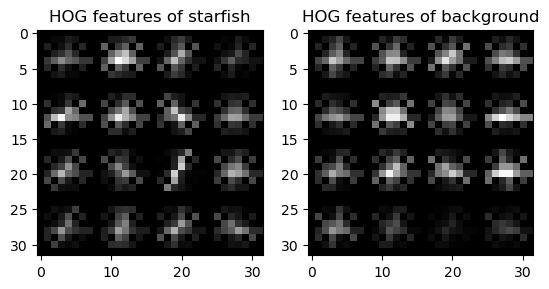

In [63]:
# Extract the hog feature of the starfish image and show it
# (32,32) based on the most common width and height of bounding boxes
path = pos_data_df.filepath[0]
box = pos_data_df.annotations[0][0]
pos_img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)[box['y']:box['y']+box['height'], box['x']:box['x']+box['width']]
pos_img_resized = cv2.resize(pos_img, (32, 32))
pos_img_gray = cv2.cvtColor(pos_img_resized, cv2.COLOR_RGB2GRAY)
pos_features, pos_img_hog = hog(pos_img_gray, orientations=9, pixels_per_cell=(8, 8), 
                        cells_per_block=(2,2), visualize=True, feature_vector=False)
print(features.shape)

# Extract the hog feature of the background image and show it
path = neg_data_df.filepath[0]
box = neg_data_df.annotations[0][0]
neg_img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)[box['y']:box['y']+box['height'], box['x']:box['x']+box['width']]
neg_img_resized = cv2.resize(neg_img, (32, 32))
neg_img_gray = cv2.cvtColor(neg_img_resized, cv2.COLOR_RGB2GRAY)
features, neg_img_hog = hog(neg_img_gray, orientations=9, pixels_per_cell=(8, 8), 
                        cells_per_block=(2,2), visualize=True, feature_vector=False)
print(features.shape)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(pos_img_hog, 'gray')
plt.title("HOG features of starfish")
plt.subplot(1,2,2)
plt.imshow(neg_img_hog, 'gray')
plt.title("HOG features of background")

# Buliding Classifier

In [22]:
def get_hog_features(image, windowSize):
    '''Get hog features for single image'''
    img_resized = cv2.resize(image, windowSize)
    img_gray = cv2.cvtColor(img_resized,cv2.COLOR_RGB2GRAY)
    features = hog(img_gray, orientations=9, pixels_per_cell=(8, 8), 
                  cells_per_block=(2,2), visualize=False, feature_vector=True)
    return features

def extract_features(image, boxes):
    '''Get features for each bounding box and conecntrate them'''
    features = []
#     we can add other features (like HOG of RGB three channels) for further improvement
    for box in boxes:
        roi = img[box['y']:box['y']+box['height'], box['x']:box['x']+box['width']]
        hog_features = get_hog_features(roi, windowSize)
        features.append(hog_features)
    return features

In [172]:
# Build and label starfish and background data
start_time = time.time()

pos_images = []
neg_images = []
pos_labels = np.ones(np.sum(pos_data_df.annotations.str.len()))
neg_labels = np.zeros(np.sum(neg_data_df.annotations.str.len()))

for i in range(len(pos_data_df)):
    path = pos_data_df.filepath[i]
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    bboxes = pos_data_df.annotations[i]
    pos_images += extract_features(img, bboxes)

for j in range(len(neg_data_df)):
    path = neg_data_df.filepath[j]
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    bboxes = neg_data_df.annotations[j]
    neg_images += extract_features(img, bboxes)
    


In [173]:
# Split training data and testing data for SVM classifier
x = np.asarray(pos_images + neg_images)
y = np.asarray(list(pos_labels) + list(neg_labels))
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [174]:
# Train the SVM classifier
svc = SVC(probability=True) 
svc.fit(x_train,y_train)

y_true = y_test
y_pred = svc.predict(x_test)

end_time = time.time()
print(f"Time for training: {end_time - start_time:.2f}s")
print("Classification report:")
print(classification_report(y_true, y_pred, labels=["Background", "Starfish"]))

Time for training: 262.75s
              precision    recall  f1-score   support

           1       0.95      0.99      0.97      2380
           0       0.94      0.60      0.74       296

    accuracy                           0.95      2676
   macro avg       0.95      0.80      0.85      2676
weighted avg       0.95      0.95      0.95      2676



In [ ]:
# # Use OneClassSVM without negative samples
# x_train, x_test = train_test_split(np.asarray(pos_images), test_size=0.2, random_state=42)
# ocsvm = OneClassSVM(nu=0.01, kernel = 'rbf', gamma = 'auto').fit(x_train)

# y = ocsvm.predict(x_train)
# print(y)
# cls, cnts = np.unique(y, return_counts=True)
# print('Inlier train', cls, cnts / cnts.sum())

# y = ocsvm.predict(x_test)
# cls, cnts = np.unique(y, return_counts=True)
# print('Inlier test', cls, cnts / cnts.sum())

# Detecting: Sliding Window and Heatmap

In [31]:
def sliding_window(image, windowSize, step):
    '''Fixed step sliding selection of all regions'''
    boxes = []
    rows, cols = image.shape[:2]
    (w_width, w_height) = windowSize
#     start from 0 to the end of image - window size
    for x in range(0, cols - w_width , step):
        for y in range(0, rows - w_height, step):
            boxes.append({'x': x, 'y':y, 'width':w_width, 'height':w_height})
    return boxes
    

In [32]:
# Use heatmap to reduce duplicate and false detection
# There is another way, Non-max supperssing, can be used for further imrpovment.
def init_heatmap(image):
    '''Initial a heatmap'''
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float64)
    return heatmap

def add_heat(heatmap, bbox_list):
    '''Add value to the potential region'''
    for box in bbox_list:
        heatmap[box['y']:box['y']+box['height'], box['x']:box['x']+box['width']] += 1
    return heatmap

def apply_threshold(heatmap, threshold):
    '''Scale the heatmap to 0-1, and apply threshold to limit'''
    heatmap_norm = (heatmap - heatmap.min())/ (heatmap.max() - heatmap.min())
    plt.imshow(np.asarray(heatmap_norm * 255).astype(np.uint8), "gray")
    plt.show()
    heatmap_norm[heatmap_norm < threshold] = 0
    heatmap_scaled = np.asarray(heatmap_norm * 255).astype(np.uint8)
    plt.imshow(heatmap_scaled, "gray")
    plt.show()
    return heatmap_scaled

In [63]:
# Hyperparameters
windowSize = (32,32)
step = 6

In [168]:
# Test the detecting result on single image
start_time = time.time()

# Load testing image
idx = 0
path = test_data_df.filepath[idx]
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
bboxes_true = test_data_df.annotations[idx]

# Get the HOG features of all subregions
windows = sliding_window(img, windowSize, step)
windows_features = extract_features(img, windows)

# Predict all subregions
result = svc.predict_proba(windows_features)
# result = ocsvm.predict(windows_features)


In [169]:
# Get potential regions
conf_threshold = 0.9

bbox_list = []
for i in range(len(windows)):
    if result[i][1] > conf_threshold:
        bbox_list.append(windows[i])
        

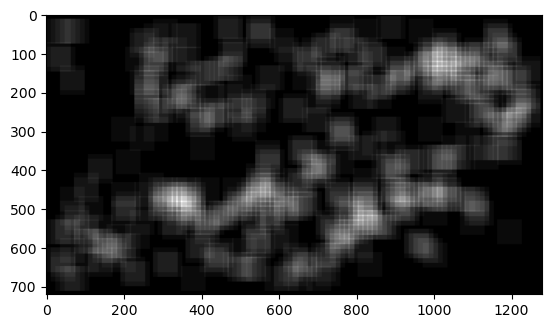

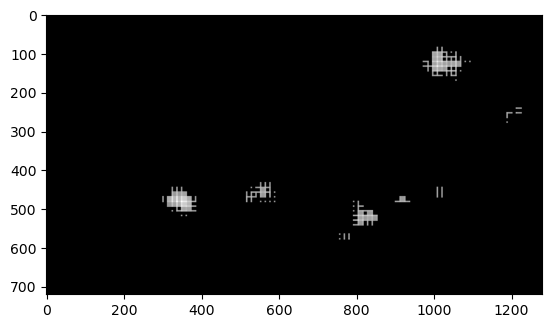

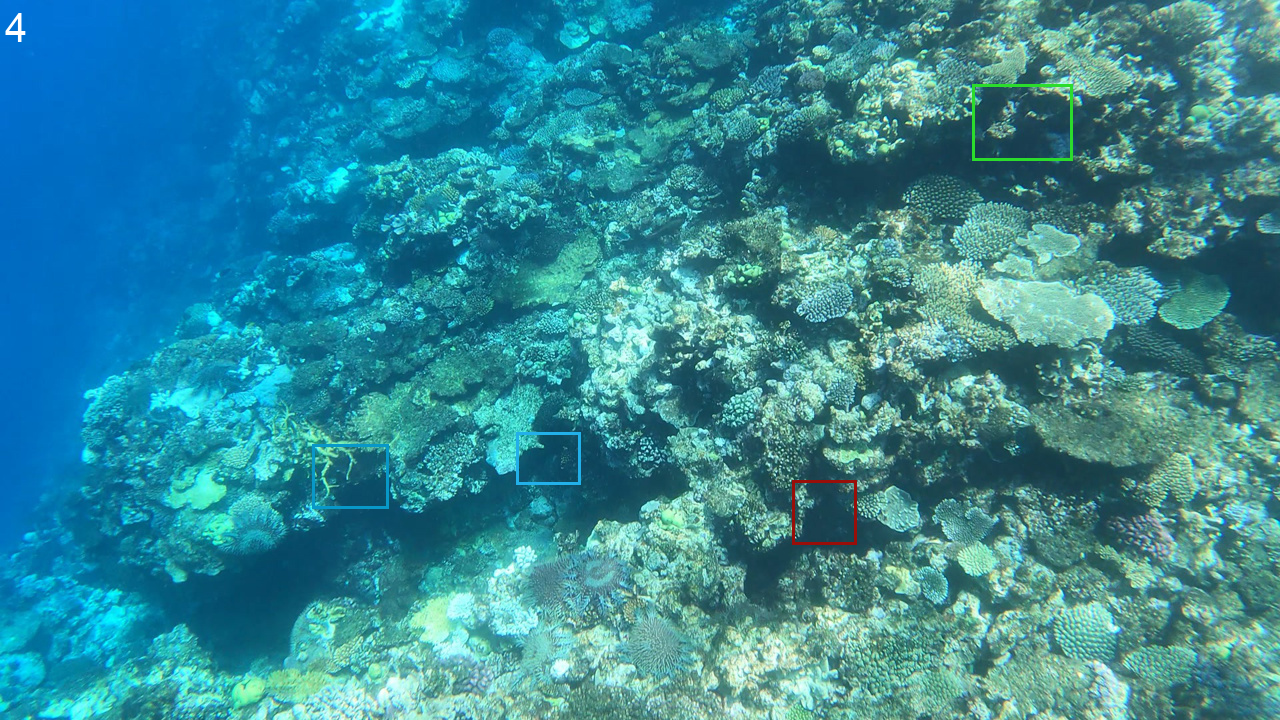

Time for testing single image: 23.31s


In [170]:
# Show final result
threshold = 0.6

# Use heatmap
heatmap = init_heatmap(img)
heatmap = add_heat(heatmap, bbox_list)
heatmap = apply_threshold(heatmap, threshold)

# Get final bounding boxes
cnts, _ = cv2.findContours(heatmap, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
bboxes = []
for c in cnts:
# If a contour is too small or too big, then don't consider it
    if cv2.contourArea(c) < 32*32 or cv2.contourArea(c) > 100*100:
            continue
    (x,y,w,h) = cv2.boundingRect(c)
    bboxes.append({'x': x, 'y':y, 'width':w, 'height':h})

plot_img(path, bboxes)
end_time = time.time()
print(f"Time for testing single image: {end_time-start_time:.2f}s")